In [149]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [150]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)
print(df.head())

   PERMNO        date TICKER   BIDLO   ASKHI    PRC      VOL        RET  \
0   11850  1925-12-31    NaN  45.500  46.375  46.00  41400.0          C   
1   11850  1926-01-02    NaN  45.750  46.375  46.00   8400.0   0.000000   
2   11850  1926-01-04    NaN  45.250  46.250  45.50  18700.0  -0.010870   
3   11850  1926-01-05    NaN  45.125  45.625  45.25  17600.0  -0.005495   
4   11850  1926-01-06    NaN  44.875  45.375  45.00   7900.0  -0.005525   

   OPENPRC  
0   45.750  
1   46.375  
2   46.000  
3   45.500  
4   45.125  


In [151]:
# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filter the data for a specific date range (example: from 2000-01-01 to 2010-12-31)
start_date = '2000-01-31'
end_date = '2018-08-30'
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [152]:
# only keep the price column
df = df[["PRC"]].copy()
print(df.head())
df.describe()

           PRC
19781  83.4375
19782  83.1875
19783  83.8125
19784  82.3750
19785  80.8750


,PRC
count,4677.000000
mean,72.304145
std,18.584397
min,30.270000
25%,60.450000
50%,78.780000
75%,86.460000
max,104.380000


In [153]:
# check for missing values
print("Missing values:", df.isnull().sum())

Missing values: PRC    0
dtype: int64


In [154]:
# remove missing values
df = df.dropna()

In [155]:
# Augmented Dickey Fuller (ADF) test to check if the price is stationary

from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df)

# Print the result of the ADF test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations Used:", adf_result[3])
print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")


ADF Statistic: -1.8065101279597926
p-value: 0.3772344194739909
Used Lag: 18
Number of Observations Used: 4658
Critical Values: {'1%': -3.431754660230483, '5%': -2.862160697900221, '10%': -2.5671003999674795}
Conclusion: The series is non-stationary


In [156]:
print(type(df))
print(df.columns)  # Check the column names to verify 'PRC' is still there

<class 'pandas.core.frame.DataFrame'>
Index(['PRC'], dtype='object')


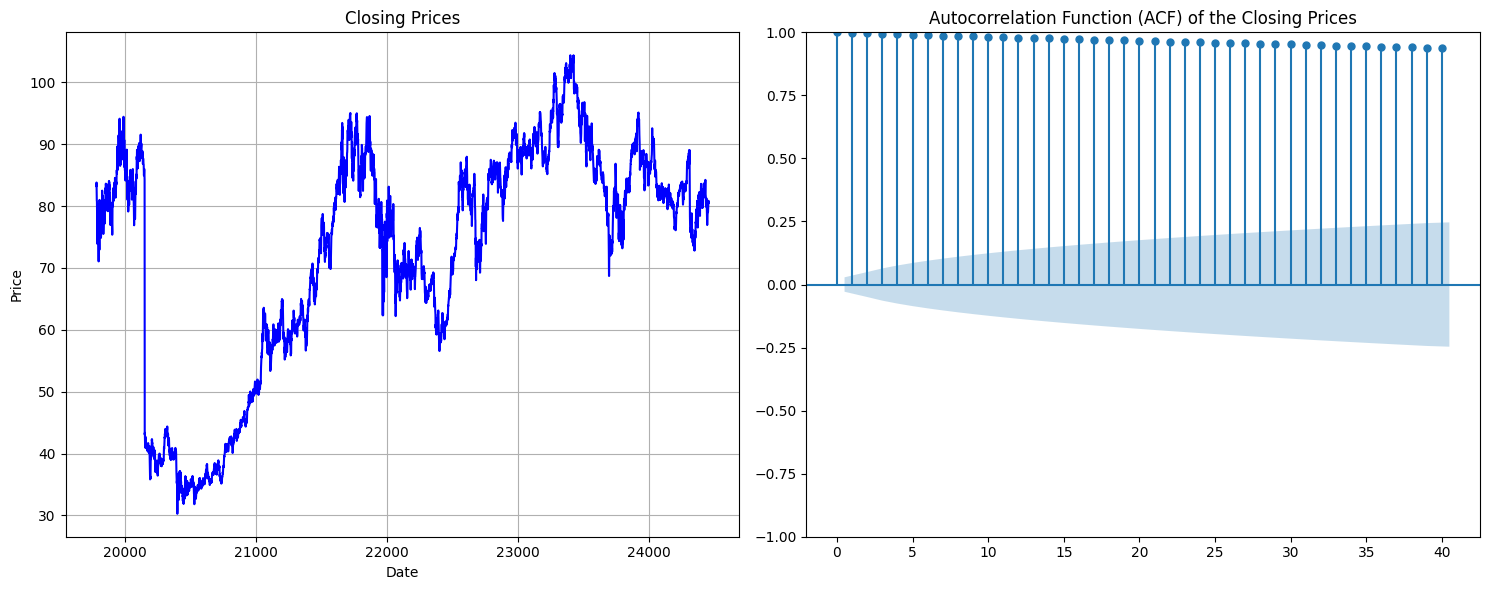

In [157]:
from statsmodels.graphics.tsaplots import plot_acf

# Create a figure with 2 subplots (one for the price and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the closing prices (Price vs Time)
axes[0].plot(df.index, df['PRC'], label="Closing Price", color='blue')
axes[0].set_title("Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")
axes[0].grid(True)

# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(df['PRC'], lags=40, ax=axes[1])  # lags=40 shows the ACF for up to 40 lags
axes[1].set_title('Autocorrelation Function (ACF) of the Closing Prices')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

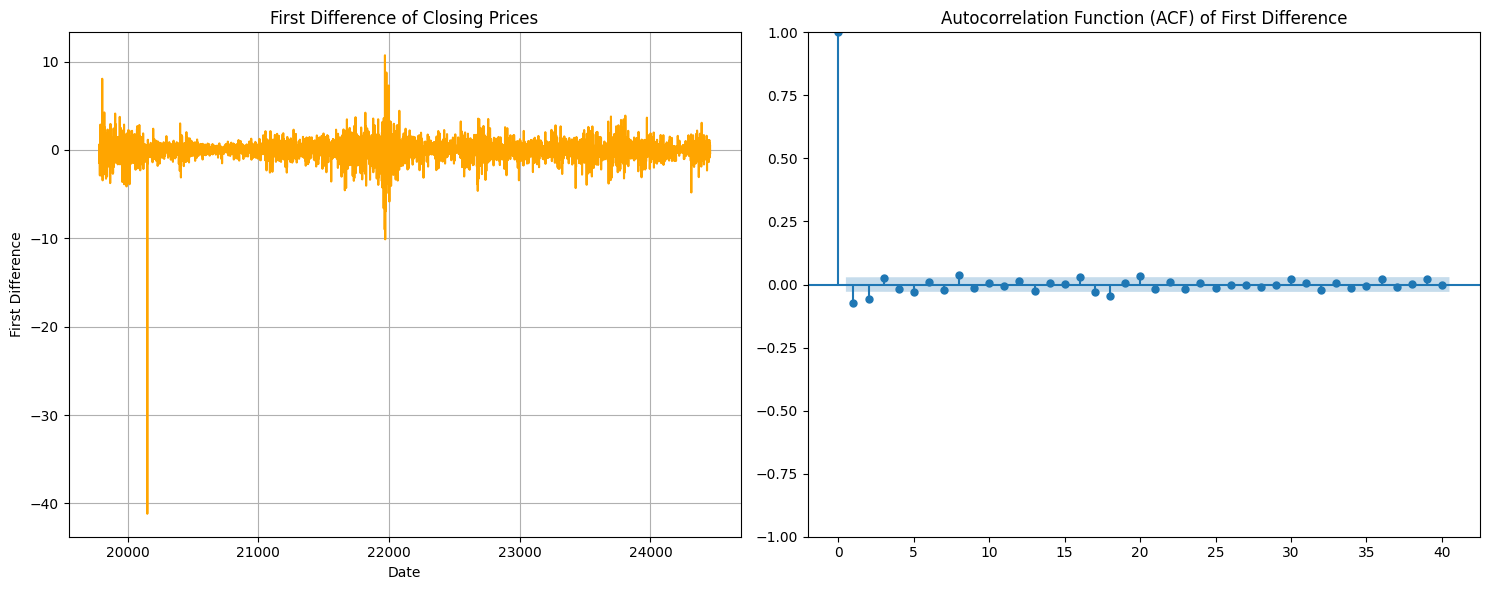

In [158]:
# Calculate the first difference of the closing prices
df['first_difference'] = df['PRC'].diff()

# Create a figure with 2 subplots (one for the first difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first difference (First Difference vs Time)
axes[0].plot(df.index, df['first_difference'], label="First Difference", color='orange')
axes[0].set_title("First Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("First Difference")
axes[0].grid(True)

# Plot the ACF for the first difference (on the second subplot)
plot_acf(df['first_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of First Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

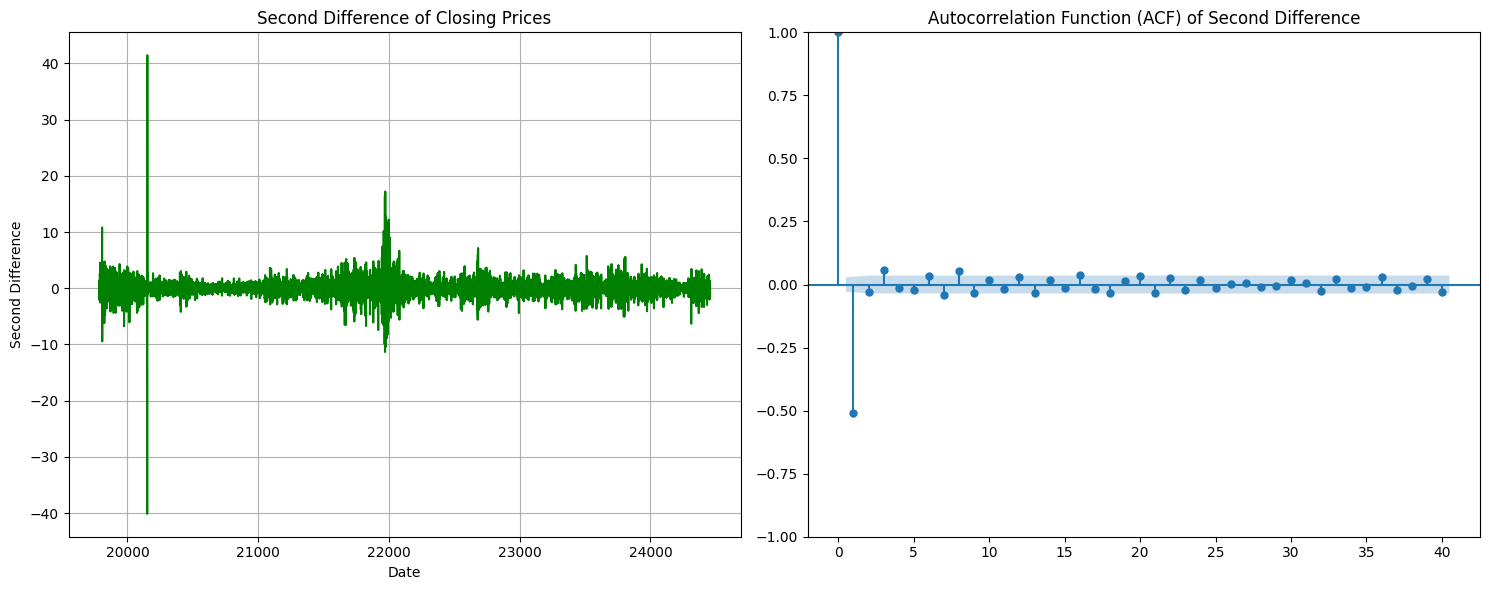

In [159]:
# Calculate the second difference (difference of the first differences)
df['second_difference'] = df['first_difference'].diff()

# Create a figure with 2 subplots (one for the second difference and one for the ACF)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the second difference (Second Difference vs Time)
axes[0].plot(df.index, df['second_difference'], label="Second Difference", color='green')
axes[0].set_title("Second Difference of Closing Prices")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Second Difference")
axes[0].grid(True)

# Plot the ACF for the second difference (on the second subplot)
plot_acf(df['second_difference'].dropna(), lags=40, ax=axes[1])  # dropna() to avoid NaN values
axes[1].set_title('Autocorrelation Function (ACF) of Second Difference')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

In [160]:
from pmdarima.arima.utils import ndiffs

# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(df['PRC'])

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


<Figure size 1000x600 with 0 Axes>

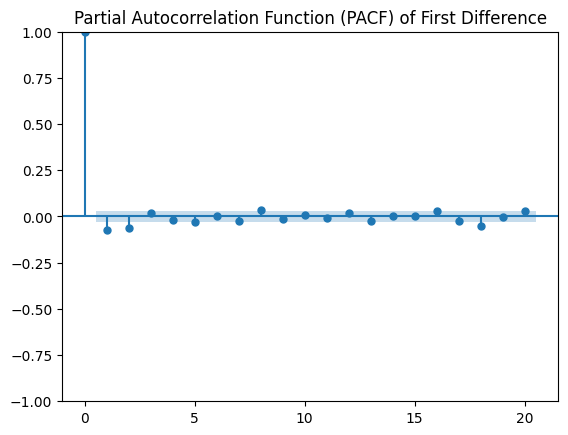

In [161]:
# p is the order of the autoregressive term

from statsmodels.graphics.tsaplots import plot_pacf

# Plot the PACF for the first difference
plt.figure(figsize=(10, 6))
plot_pacf(df['first_difference'].dropna(), lags=20)  # dropna() to avoid NaN values
plt.title('Partial Autocorrelation Function (PACF) of First Difference')
plt.show()


In [162]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (AR(2), I(1), MA(2)) based on the PACF
model = ARIMA(df['PRC'], order=(2, 1, 2))  # AR(2), I(1), MA(2)
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    PRC   No. Observations:                 4677
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7626.192
Date:                Wed, 20 Nov 2024   AIC                          15262.383
Time:                        12:07:25   BIC                          15294.634
Sample:                             0   HQIC                         15273.725
                               - 4677                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3764      0.139     -2.699      0.007      -0.650      -0.103
ar.L2         -0.1541      0.097     -1.581      0.114      -0.345       0.037
ma.L1          0.2996      0.141      2.132      0.0

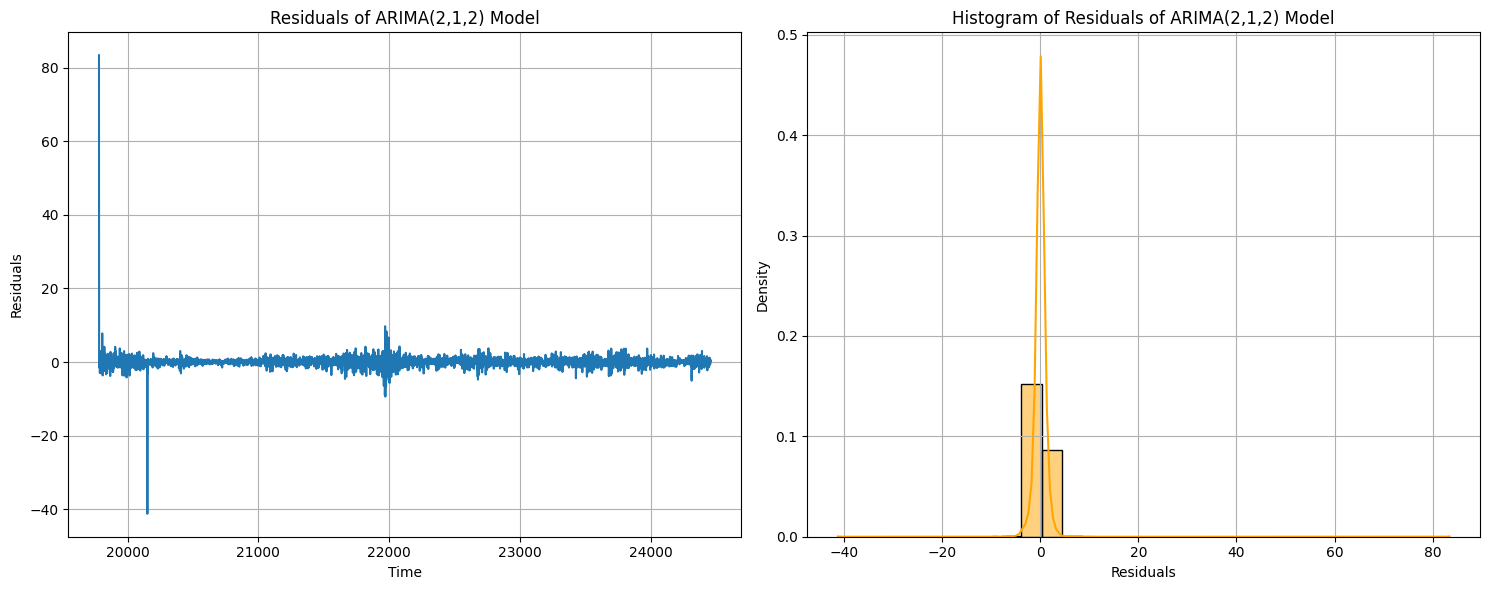

In [163]:
# Get the residuals (difference between observed and fitted values)
residuals = model_fit.resid

# Create a figure with 2 subplots (one for residuals and one for histogram)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals of ARIMA(2,1,2) Model')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot the histogram of residuals
sns.histplot(residuals, kde=True, bins=30, color='orange', stat='density', ax=axes[1])  # KDE = Kernel Density Estimation
axes[1].set_title('Histogram of Residuals of ARIMA(2,1,2) Model')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

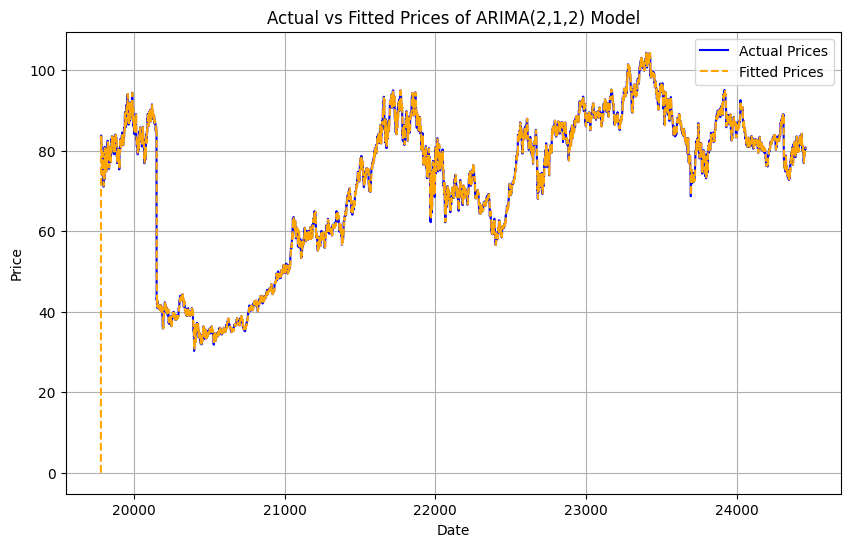

In [164]:
# ACTUAL VS FITTED VALUES OVER TRAINING DATA

# Get the fitted values (predicted prices)
fitted_values = model_fit.fittedvalues

# Plot actual vs fitted prices
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['PRC'], label='Actual Prices', color='blue')
plt.plot(df.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')
plt.title('Actual vs Fitted Prices of ARIMA(2,1,2) Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


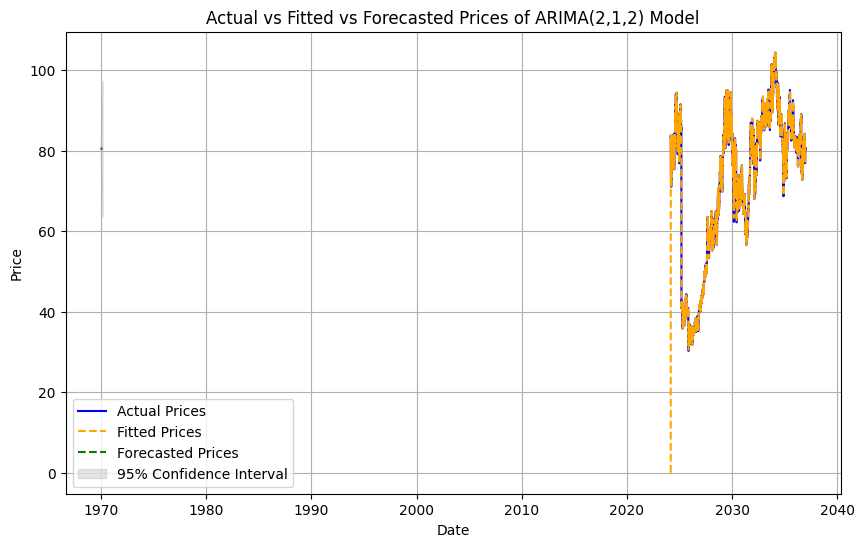

In [165]:
# Forecast the next 60 steps beyond the training data (e.g., 60 future periods)
forecast_steps = 60
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Standard error of the forecast
stderr = forecast_results.se_mean

# Confidence intervals for the forecast
conf_int = forecast_results.conf_int(alpha=0.05)

# Plot actual vs fitted vs forecasted prices
plt.figure(figsize=(10, 6))

# Plot the actual values (training data)
plt.plot(df.index, df['PRC'], label='Actual Prices', color='blue')

# Plot the fitted values (model predictions for the training period)
plt.plot(df.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')

# Plot the forecasted values (future predictions beyond the training period)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='D')[1:]  # Generate future dates
plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='green', linestyle='--')

# Add confidence intervals for the forecast
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

# Customize the plot
plt.title('Actual vs Fitted vs Forecasted Prices of ARIMA(2,1,2) Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()